# Создание модели для определения оптимальной температуры

## Описание проекта
Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

## Описание данных
Данные состоят из нескольких файлов, полученных из разных источников:
data_arc_new.csv — данные об электродах;
data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
data_gas_new.csv — данные о продувке сплава газом;
data_temp_new.csv — результаты измерения температуры;
data_wire_new.csv — данные о проволочных материалах (объём);
data_wire_time_new.csv — данные о проволочных материалах (время).

Файл data_arc_new.csv
* key — номер партии;
* Начало нагрева дугой — время начала нагрева;
* Конец нагрева дугой — время окончания нагрева;
* Активная мощность — значение активной мощности;
* Реактивная мощность — значение реактивной мощности.

Файл data_bulk_new.csv
* key — номер партии;
* Bulk 1 … Bulk 15 — объём подаваемого материала.

Файл data_bulk_time_new.csv
* key — номер партии;
* Bulk 1 … Bulk 15 — время подачи материала.

Файл data_gas_new.csv
* key — номер партии;
* Газ 1 — объём подаваемого газа.

Файл data_temp_new.csv
* key — номер партии;
* Время замера — время замера;
* Температура — значение температуры.

Файл data_wire_new.csv
* key — номер партии;
* Wire 1 … Wire 15 — объём подаваемых проволочных материалов.

Файл data_wire_time_new.csv
* key — номер партии;
* Wire 1 … Wire 9 — время подачи проволочных материалов.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec

from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

RANDOM_STATE = 60524

## Загрузка и обзор данных

In [2]:
try:
    data_arc_new = pd.read_csv("data_arc_new.csv", parse_dates=[1,2])
    data_bulk_new = pd.read_csv("data_bulk_new.csv")
    data_bulk_time_new = pd.read_csv("data_bulk_time_new.csv", parse_dates=list(range(1, 16)))
    data_gas_new = pd.read_csv("data_gas_new.csv")
    data_temp_new= pd.read_csv("data_temp_new.csv", parse_dates=[1])
    data_wire_new = pd.read_csv("data_wire_new.csv")
    data_wire_time_new = pd.read_csv("data_wire_time_new.csv", parse_dates=list(range(1, 10)))
except:
    data_arc_new = pd.read_csv("/datasets/data_arc_new.csv", parse_dates=[1,2])
    data_bulk_new = pd.read_csv("/datasets/data_bulk_new.csv")
    data_bulk_time_new = pd.read_csv("/datasets/data_bulk_time_new.csv", parse_dates=list(range(1, 16)))
    data_gas_new = pd.read_csv("/datasets/data_gas_new.csv")
    data_temp_new= pd.read_csv("/datasets/data_temp_new.csv", parse_dates=[1])
    data_wire_new = pd.read_csv("/datasets/data_wire_new.csv")
    data_wire_time_new = pd.read_csv("/datasets/data_wire_time_new.csv", parse_dates=list(range(1, 10)))

In [3]:
def make_view(df):
    df.info()
    display(df.head())

In [4]:
make_view(data_arc_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [5]:
make_view(data_bulk_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [6]:
make_view(data_bulk_time_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.3 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [7]:
make_view(data_gas_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [8]:
make_view(data_temp_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [9]:
make_view(data_wire_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
make_view(data_wire_time_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


## Исследовательский анализ каждой таблицы в отдельности

Рассмотрим таблицу с данными об электродах

In [11]:
data_arc_new.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [12]:
data_arc_new.isna().mean()

key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64

Как видим пропусков в данных нет, теперь посмотри на численные характеристики

In [13]:
data_arc_new.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


Видим нереально маленькое значение в реактивной мощности, посмотрим есть ли ещё похожие

In [14]:
data_arc_new['Реактивная мощность'].sort_values(ascending=True).head(5)

9780    -715.479924
709        0.153777
3290       0.153921
11794      0.155221
6130       0.156525
Name: Реактивная мощность, dtype: float64

Такая аномалия всего лишь одна, так что удалим её

In [15]:
data_arc_new = data_arc_new[data_arc_new['Реактивная мощность'] > 0]

Построим графики распределения для численных величин

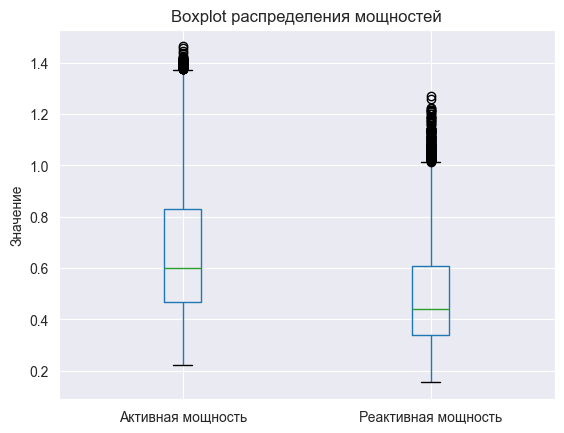

In [16]:
data_arc_new.boxplot(column=['Активная мощность', 'Реактивная мощность'])
plt.title('Boxplot распределения мощностей')
plt.ylabel('Значение')
plt.show()

Теперь рассмотри датафрейм с данными об объёме сыпучих материалов

In [17]:
data_bulk_new.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [18]:
data_bulk_new.isna().mean()

key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

Как видим большинство значений в принципе это пропуски, но мы можем заполнить их нулями т.к. пропуск в данном случае означает отсутствие добавки

In [19]:
data_bulk_new.fillna(0, inplace=True)

Теперь рассмотри численные характеристики

In [20]:
data_bulk_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Явных аномалий не видно

Рассмотрим таблицу с временем добавления сыпучих материалов

In [21]:
data_bulk_time_new.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [22]:
data_bulk_time_new.isna().mean()

key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

Пропуски заполнить мы никак не можем, как и определить наличие каких либо аномалий только по этой таблице

Рассмотрим датафрейм с данными о продувке сплава газом

In [23]:
data_gas_new.head(5)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [24]:
data_gas_new.isna().mean()

key      0.0
Газ 1    0.0
dtype: float64

В этом датафрейме пропусков нет, рассмотри численные характеристики

In [25]:
data_gas_new.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


В принципе все значения в норме.

Рассмотрим таблицу с данными о температурных замерах

In [26]:
data_temp_new.head(5)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [27]:
data_temp_new.isna().mean()

key             0.000000
Время замера    0.000000
Температура     0.189421
dtype: float64

Так данные температуре являются целевым признаком, то заполнить пропуски в них мы никак не можем и должны их удалить.

In [28]:
data_temp_new.dropna(axis=0, inplace=True)

По требованиям заказчика у нас должно быть как минимум 2 температуры в каждой исследуемой партии, так что удалим данные о партиях в которых их недостаточно

In [29]:
key_count = data_temp_new['key'].value_counts()
data_temp_new = data_temp_new[data_temp_new['key'].isin(key_count[key_count >= 2].index)]

Рассмотри данные об объёме проволочных материалов

In [30]:
data_wire_new.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
data_wire_new.isna().mean()

key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

Здесь мы как в таблице с данными о примесях можем заполнить пропуски нулями

In [32]:
data_wire_new.fillna(0, inplace=True)

In [33]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


Каких либо странностей в данных не наблюдается

Рассмотри данные об времени добавления проволочных материалов

In [34]:
data_wire_time_new.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [35]:
data_wire_time_new.isna().mean()

key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

Пропуски во времени мы никак не можем заполнить

### Промежуточный вывод по анализу отдельных таблиц
Были рассмотрены все 7 загруженный таблиц. 
* Пропуски были найдены в таблицах о сыпучих и проволочных материалах, а также в данных о температуре. Пропуски в объёме материалов мы заполнили нулями, что бы показать отсутствие добавки, пропуски во времени их добавки никак не трогали. 
* Все строки с отсутствующими значения в датафрейме с замерами температуры были удалены и после этого выбраны только те партии у которых было как минимум два замера.
* В таблице с данными о мощностях была найдена и удалена аномалия

## Объединение таблиц и создание новых признаков
* Заказчик просил использовать только те замеры, данные о которых есть во всех таблицах, так что объединять будем используя inner join.
* Было принято решение не использовать время добавления материалов как признак, так что таблицы data_bulk_time_new и data_wire_time_new использоваться не будут

Время промежуточных замеров температуры использоваться как признак тоже не буду, ведь для нас важна лишь температура с которой мы начинаем нагрев и та, до которой мы нагреваем, поэтому оставим лишь начальную и конечную температуру и разнесём их в 2 разных столбца.

In [36]:
min_date_temp = data_temp_new.groupby('key').agg({'Время замера': 'min', 'Температура': 'first'}).reset_index()
max_date_temp = data_temp_new.groupby('key').agg({'Время замера': 'max', 'Температура': 'last'}).reset_index()

min_date_temp = min_date_temp.rename(columns={'Время замера': 'min_date', 'Температура': 'first_temp'})
max_date_temp = max_date_temp.rename(columns={'Время замера': 'max_date', 'Температура': 'last_temp'})

data_temp_filtered = pd.merge(min_date_temp, max_date_temp, on='key')
data_temp_filtered.head()

,key,min_date,first_temp,max_date,last_temp
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0


Время которое прошло между замерами играет достаточно высокую роль, так что можем использовать его как признак, а вот даты уже можно удалить.

In [37]:
data_temp_filtered['measurement_time'] = ((data_temp_filtered['max_date'] - data_temp_filtered['min_date']).
                                   dt.total_seconds())

In [38]:
data_temp_filtered = data_temp_filtered[['key', 'first_temp', 'last_temp', 'measurement_time']]
data_temp_filtered

,key,first_temp,last_temp,measurement_time
0,1,1571.0,1613.0,1714.0
1,2,1581.0,1602.0,1265.0
2,3,1596.0,1599.0,1753.0
3,4,1601.0,1625.0,1220.0
4,5,1576.0,1602.0,1536.0
...,...,...,...,...
2470,2495,1570.0,1591.0,1380.0
2471,2496,1554.0,1591.0,1705.0
2472,2497,1571.0,1589.0,962.0
2473,2498,1591.0,1594.0,1520.0


Так как на каждую итерацию нагрева тратилась разная мощность, то мы можем для получения 1 строки суммировать мощность для каждого сплава.

In [39]:
data_arc_sum = data_arc_new.groupby('key')[['Активная мощность', 'Реактивная мощность']].sum()
data_arc_sum = data_arc_sum.rename(
    columns={'Активная мощность': 'active_power', 'Реактивная мощность': 'reactive_power'}
)

Объединим полученные датафреймы

In [40]:
final_data = pd.merge(data_temp_filtered, data_arc_sum, on='key', how='inner')

В этот же датафрейм добавим информацию об объёмах всех материалов и добавляемом газе.

In [41]:
final_data = pd.merge(final_data, data_gas_new, on='key', how='inner')
final_data = pd.merge(final_data, data_wire_new, on='key', how='inner')
final_data = pd.merge(final_data, data_bulk_new, on='key', how='inner')
final_data.head(5)

,key,first_temp,last_temp,measurement_time,active_power,reactive_power,Газ 1,Wire 1,Wire 2,Wire 3,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,1571.0,1613.0,1714.0,3.036730,2.142821,29.749986,60.059998,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,1581.0,1602.0,1265.0,2.139408,1.453357,12.555561,96.052315,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,1596.0,1599.0,1753.0,4.063641,2.937457,28.554793,91.160157,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,1601.0,1625.0,1220.0,2.706489,2.056992,18.841219,89.063515,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,1576.0,1602.0,1536.0,2.252950,1.687991,5.413692,89.238236,9.11456,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Колонка key нам больше не нужна и мы можем от неё избавиться

In [42]:
final_data.drop('key', axis=1, inplace=True)

### Промежуточный вывод по объединению таблиц и созданию новых признаков
Мы решили не использовать все 7 таблиц - информация о времени добавления сыпучих и проволочных материалов была признана бесполезной. Остальные же датафреймы были видоизменены и соединены с помощью nner join
* В data_arc_new были суммированы значения мощностей по каждому сплаву, а временной столбец был выкинут.
* Из data_temp мы выбрали в качестве новых столбцов начальную и конечную температуру, а также суммарное время нагревания сплава.
* data_wire_new, data_gas_new, data_bulk_new были добавлены без изменений

## Исследовательский анализ и предобработка данных объединённого датафрейма

Посмотрим на численные характеристики всех столбцов

In [43]:
def columns_analysis(df):
    for column in df.select_dtypes(exclude='object').columns:
        gs = GridSpec(1, 2, width_ratios=[5, 2], wspace=0.2, figure=plt.figure(figsize=(6, 5)))
        ax1 = plt.subplot(gs[0])
        if df[column].nunique() < 15:
            df[column].value_counts().sort_index().plot.bar()
        else:
            df[column].plot.kde()
        ax1.set_title(f"Распределение столбца {column}")
        ax2 = plt.subplot(gs[1])
        text = df[column].describe().to_string()
        ax2.text(0, 0.5, text, ha='left', va='center', fontsize=12, linespacing=1.5)
        ax2.axis('off')
        plt.show()

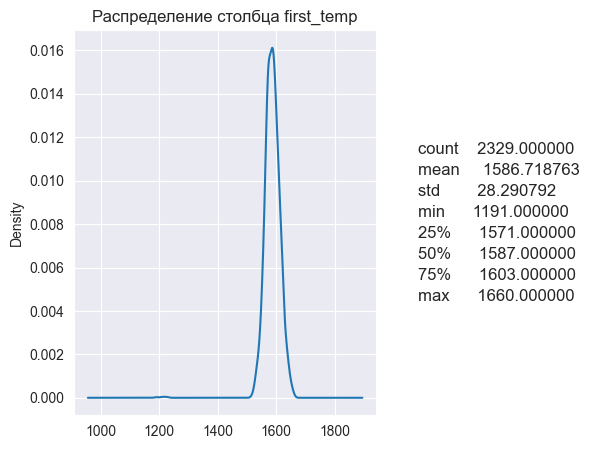

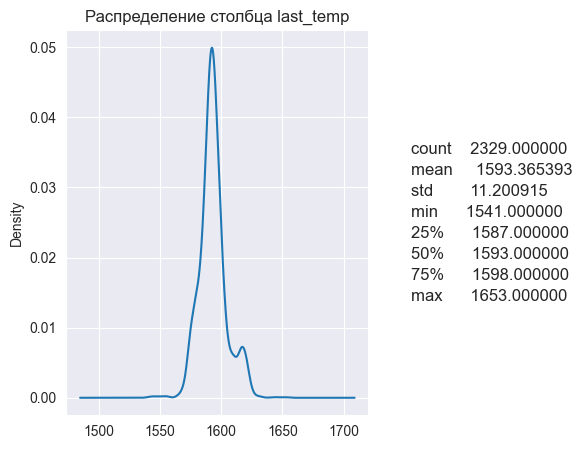

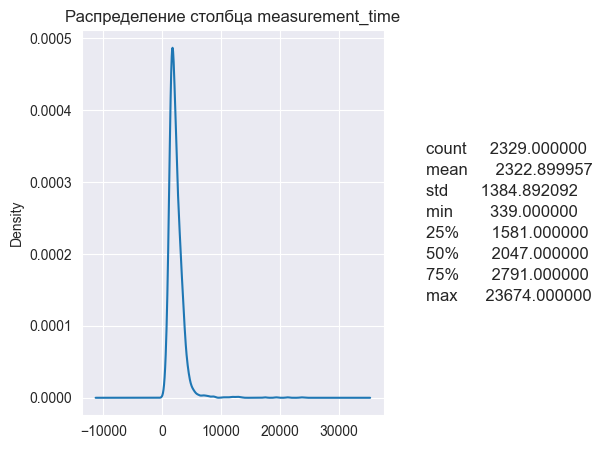

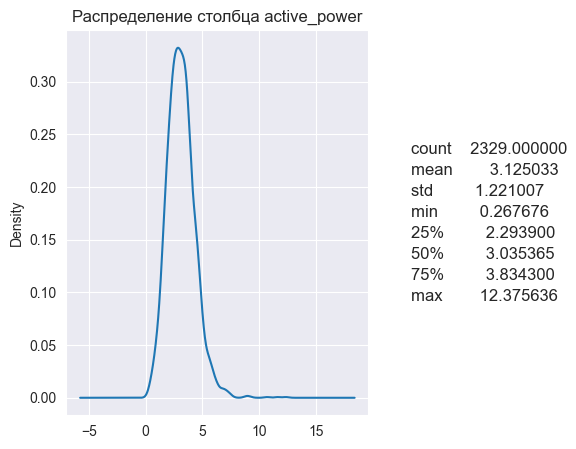

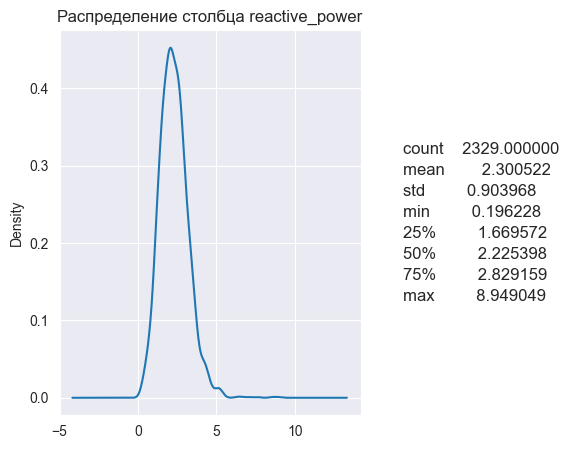

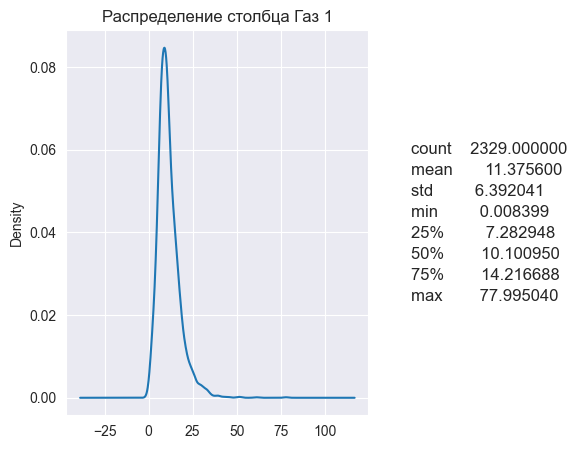

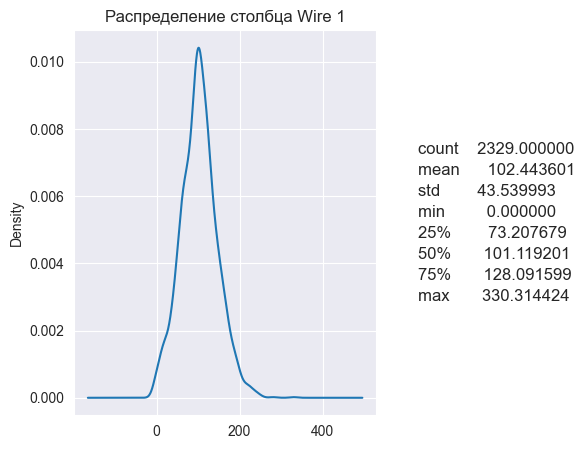

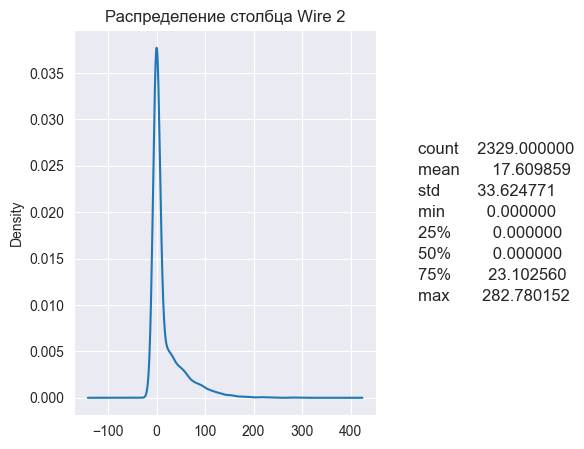

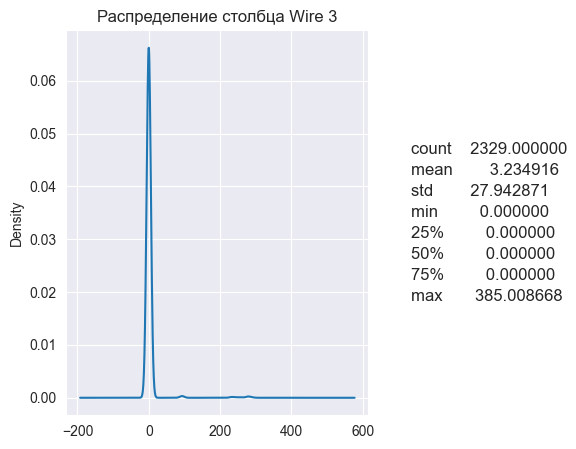

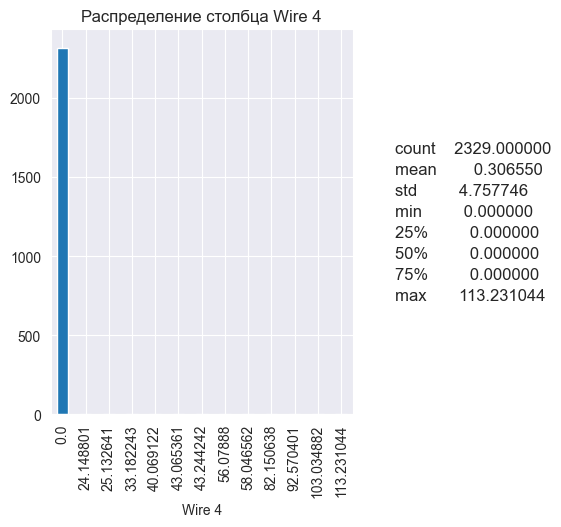

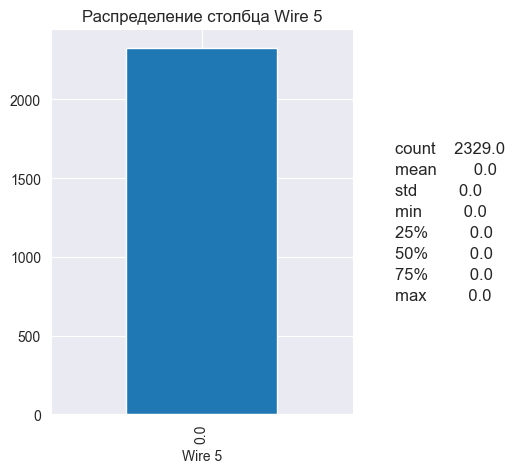

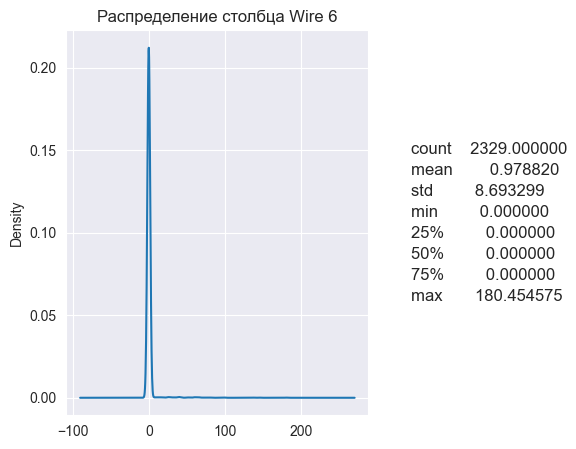

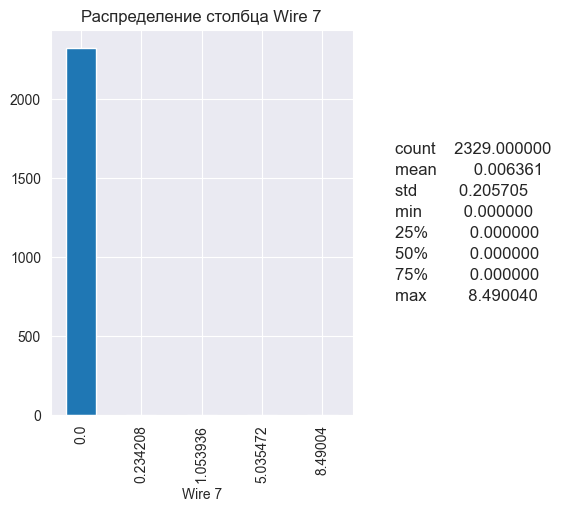

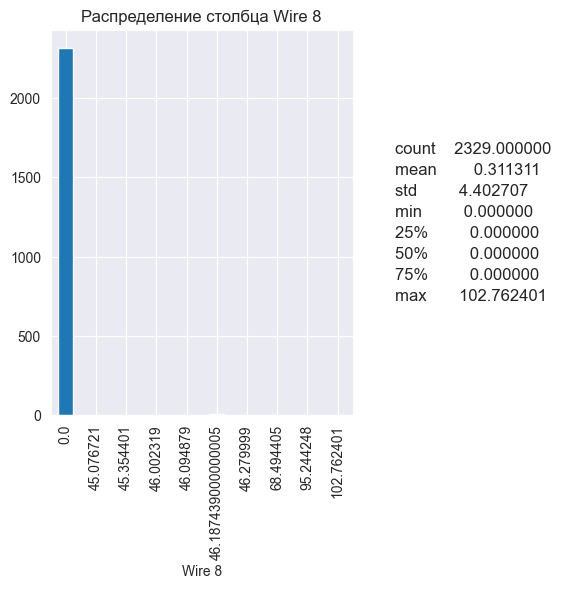

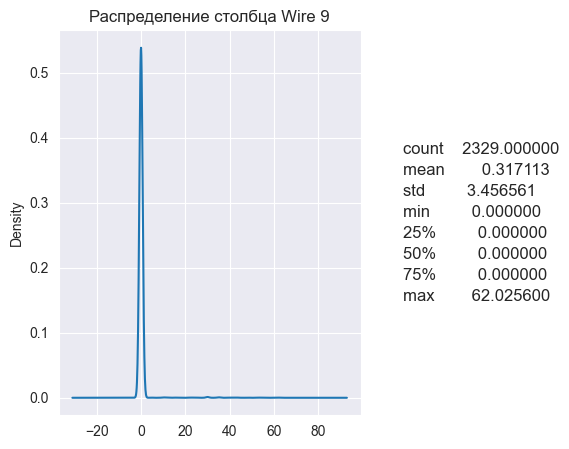

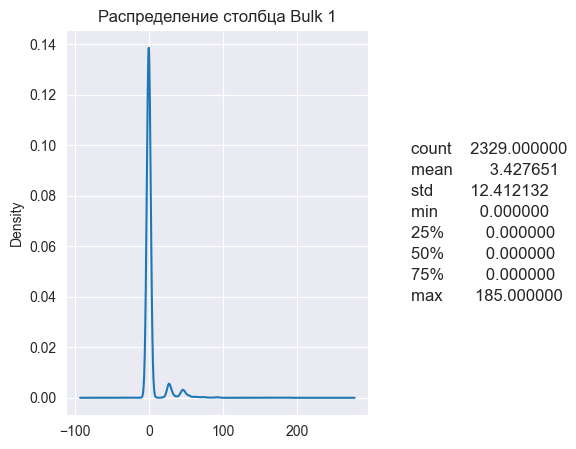

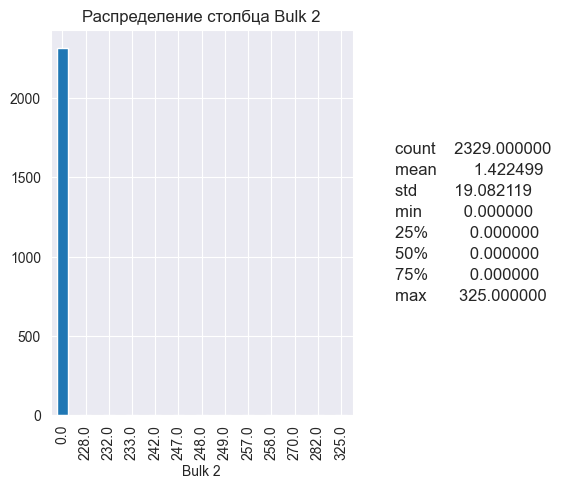

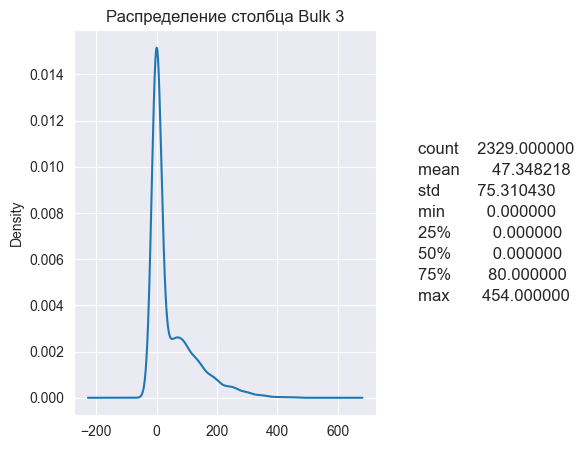

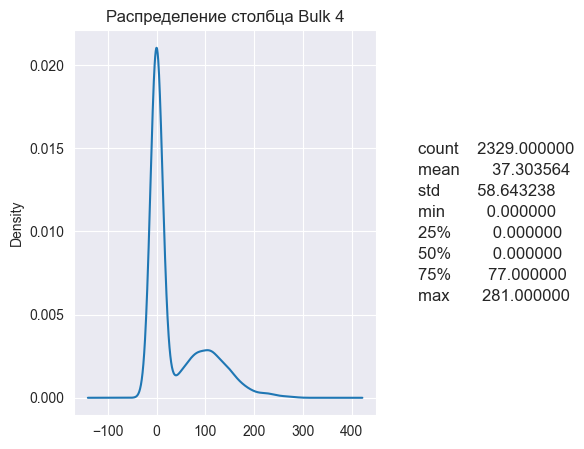

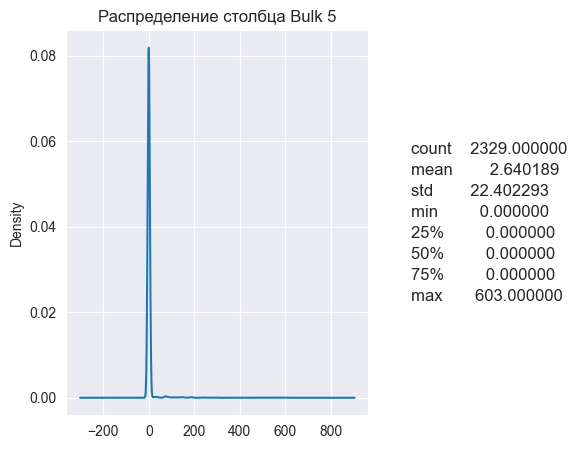

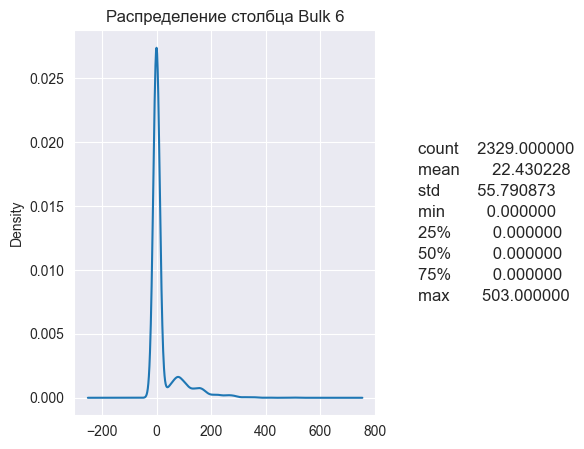

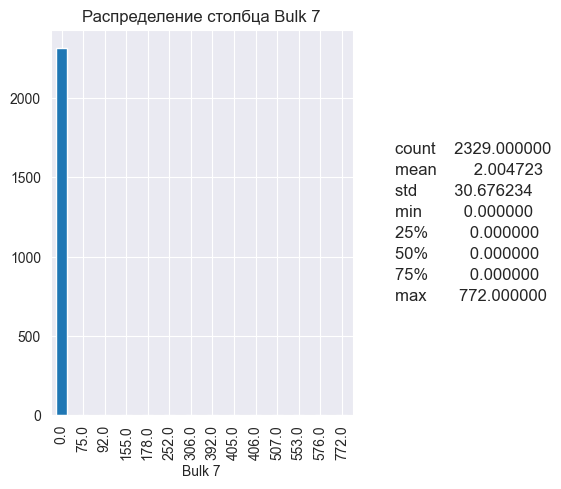

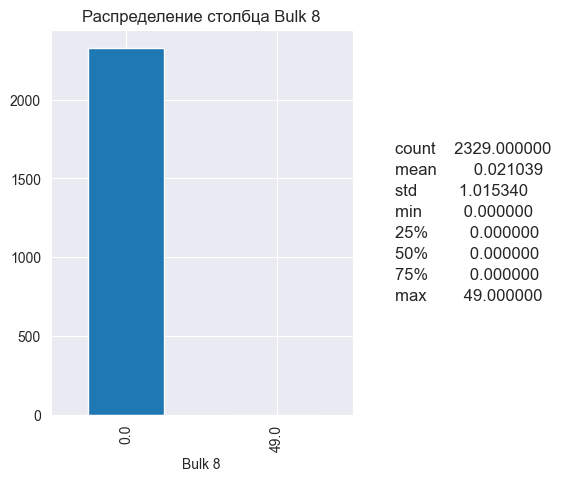

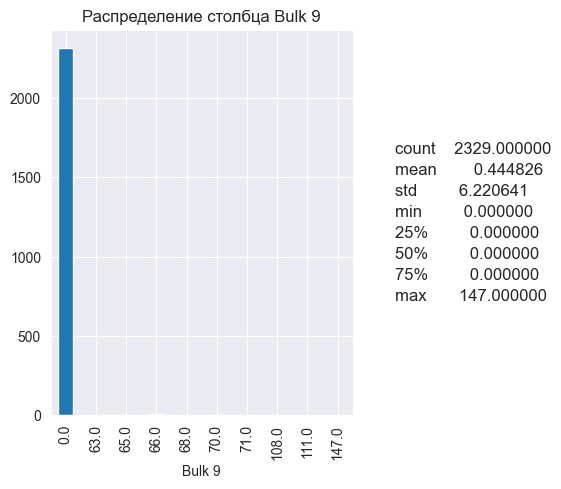

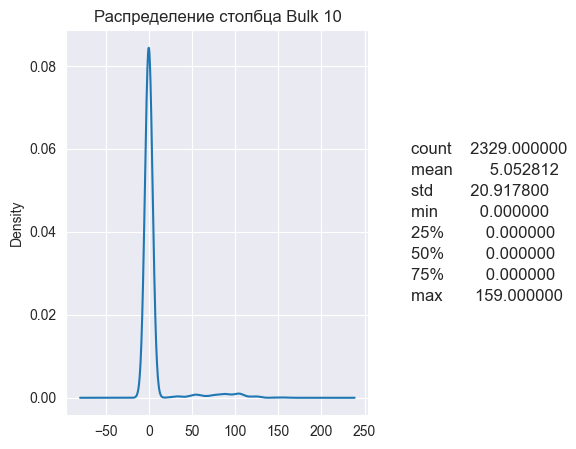

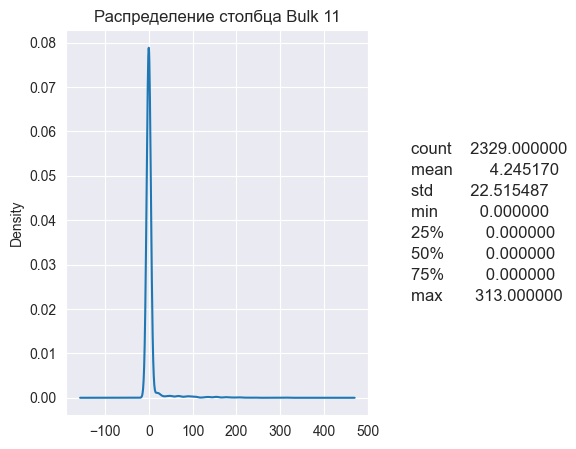

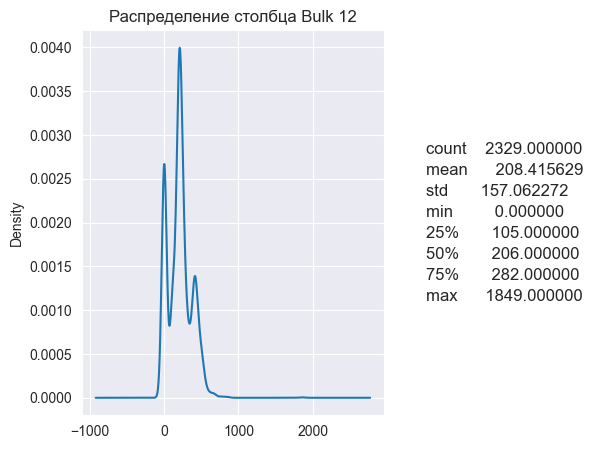

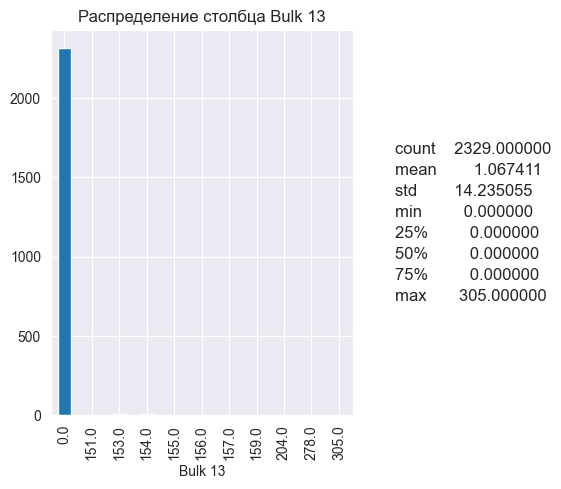

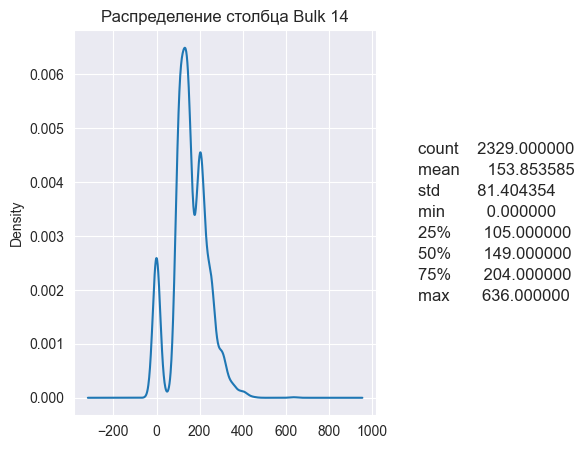

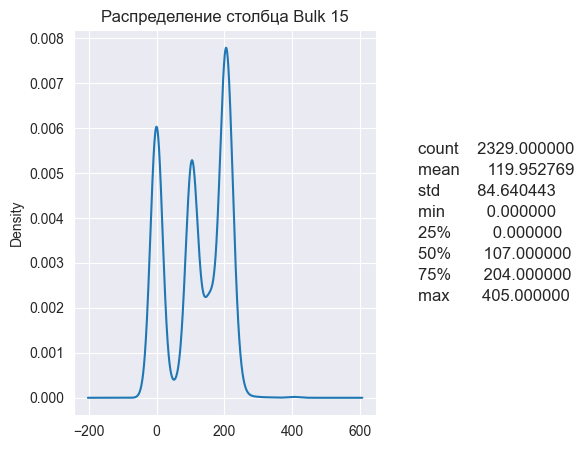

In [44]:
columns_analysis(final_data)

У столбцов Bulk 2, 7, 8, 9, 13 и Wire 4, 5, 7, 8 меньше 15 значений отличных от 0, стоит удалить такие неинформативные столбцы

In [45]:
columns_to_drop = []
for column in final_data.columns:
    if final_data[column].nunique() < 15:
        columns_to_drop.append(column)
columns_to_drop

['Wire 4',
 'Wire 5',
 'Wire 7',
 'Wire 8',
 'Bulk 2',
 'Bulk 7',
 'Bulk 8',
 'Bulk 9',
 'Bulk 13']

In [46]:
final_data.drop(columns=columns_to_drop, axis=1, inplace=True)

Построим матрицу корреляции

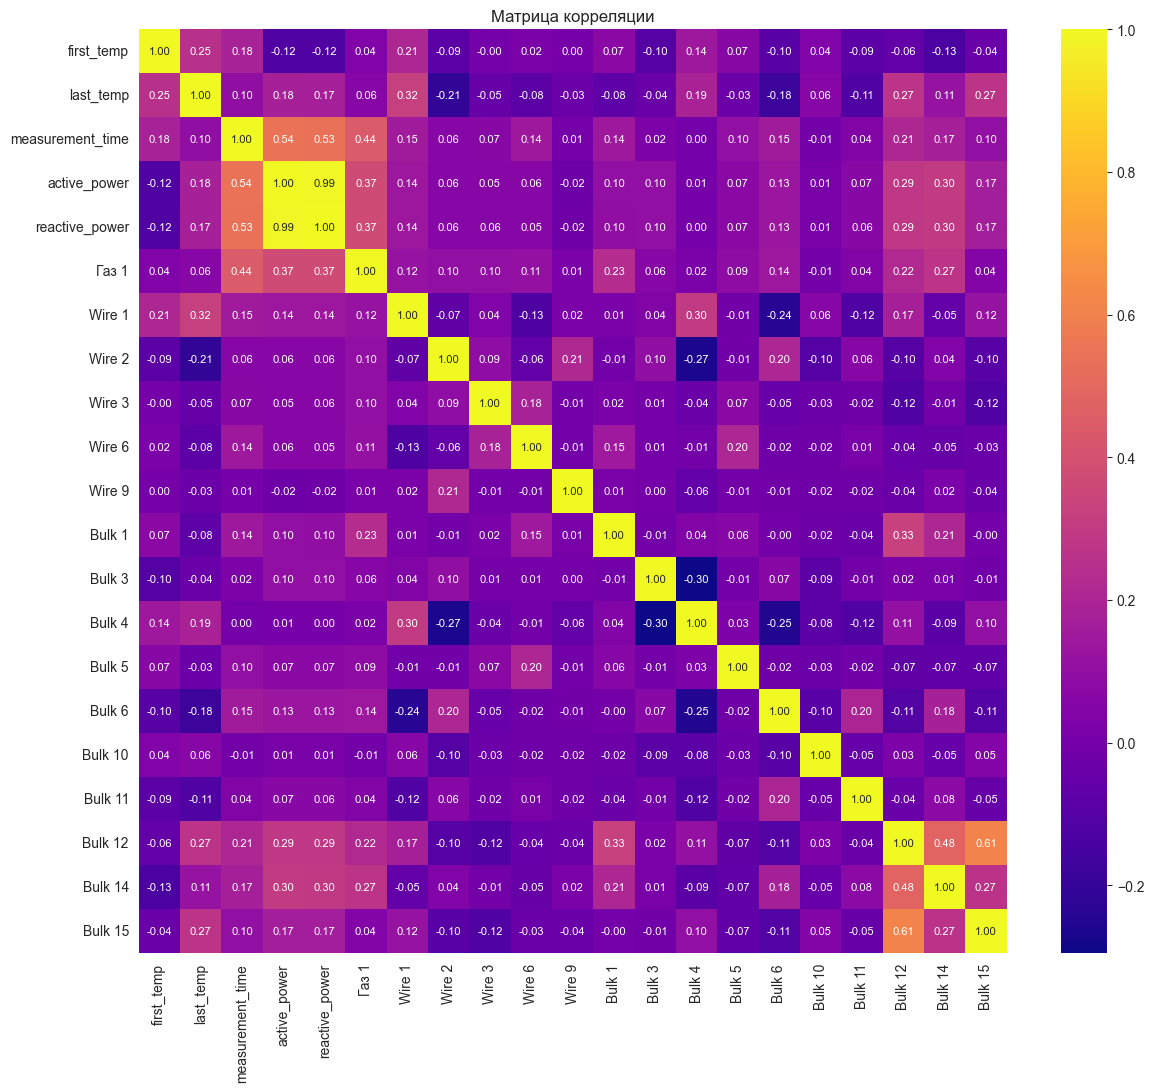

In [47]:
correlation_matrix = final_data.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='plasma', fmt=".2f", annot_kws={"size": 8})
plt.title('Матрица корреляции')
plt.show()

Целовой признак неплохо коррелирует с Начальной температурой, Wire 1 и Bulk 12, 15

Видим наличие мультиколлинеарности между разными видами мощностей, уберём столбец реактивная мощность.

In [48]:
final_data.drop(columns=['reactive_power'], inplace=True)

Разобьём нашу выборку на тренировочную и тестовую в соотношении 3:1

In [49]:
X = final_data.drop(columns=['last_temp'])
y = final_data['last_temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

Для приведения данных к одному масштабу воспользуемся StandardScaler

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Промежуточный вывод по исследовательскому анализ и предобработке данных объединённого датафрейма
Мы рассмотрели распределения значений в столбцах после объединения и провели предобработку.
* У столбцов Bulk 2, 7, 8, 9, 13 и Wire 4, 5, 7, 8 было меньше 15 значений отличных от 0, поэтому из-за отсутствия в них полезной информации они были удалены.
* Была построена матрица корреляции и выяснено, что целовой признак неплохо коррелирует с начальной температурой, Wire 1 и Bulk 12, 15
* Также была замечена мультиколлинеарность столбцов с реактивной и активной мощностями, реактивная была удалена.
* Данные разбили на тренировочную и тестовую выборки в соотношении 3 к 1.
* Данные привели к одному масштабу используя StandardScaler.

## Моделирование

Напишем сетку для перебора моделей и гиперпараметров через поиск по сетке

In [51]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 8),
        'models__min_samples_split': range(2, 8),
        'models__min_samples_leaf': range(1, 8),
        'models__max_features': range(2, 8),
    },
    {
        'models': [KNeighborsRegressor(n_jobs=-1)],
        'models__n_neighbors': range(2, 10),
        'models__weights': ['uniform', 'distance']
    },
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': np.arange(0.05, 1, 0.05),
    },
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': np.arange(0.05, 1, 0.05),
    },
    {
        'models': [ElasticNet(random_state=RANDOM_STATE)],
        'models__alpha': np.arange(0.05, 1, 0.2),
        'models__l1_ratio': np.arange(0.05, 1, 0.2),
    },
    {
        'models': [SVR()],
    },
    {
        'models': [CatBoostRegressor(verbose=0, iterations=1000,  random_state=RANDOM_STATE)],
        'models__learning_rate': np.arange(0.01, 0.05, 0.1),
        'models__depth': np.arange(6, 8, 10),
        'models__l2_leaf_reg': np.arange(0.2, 0.5, 0.8)
    }
]

Воспользуемся gridsearch для подбора оптимальной модели и её гиперпараметров

In [52]:
final_p = Pipeline(steps=[
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

grid_search = GridSearchCV(
    final_p,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
)
grid_search.fit(X_train_scaled, y_train)
best_model_regression = grid_search.best_params_

In [53]:
print('Лучшая модель и её параметры:\n\n', best_model_regression)
print ('Метрика лучшей модели на кросс-валидации:', -grid_search.best_score_)

Лучшая модель и её параметры:

 {'models': <catboost.core.CatBoostRegressor object at 0x0000017783F9E3F0>, 'models__depth': 6, 'models__l2_leaf_reg': 0.2, 'models__learning_rate': 0.01}
Метрика лучшей модели на кросс-валидации: 6.820222017265611


Как видим лучшей моделью стал catboost c достаточно близкой для необходимой, проверим его результаты на тесте, обучив модель на всей train выборке.

In [54]:
catboost_model = CatBoostRegressor(
    verbose=0,
    depth = 6,
    l2_leaf_reg = 0.2,
    learning_rate = 0.01,
    random_state = RANDOM_STATE)
catboost_model.fit(X=X_train_scaled, y=y_train)

y_pred = catboost_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error on Test Set:", mae)

Mean Absolute Error on Test Set: 6.527043285846993


Стоит проверить полученный результат на адекватность с помощью dummy модели

In [55]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train_scaled, y_train)

dummy_y_pred = dummy_model.predict(X_test_scaled)

dummy_mae = mean_absolute_error(y_test, dummy_y_pred)
print("Mean Absolute Error of Dummy Model on Test Set:", dummy_mae)

Mean Absolute Error of Dummy Model on Test Set: 7.821441412766064


Теперь как только получили наилучшую модель стоит посмотреть какие признаки для неё важны

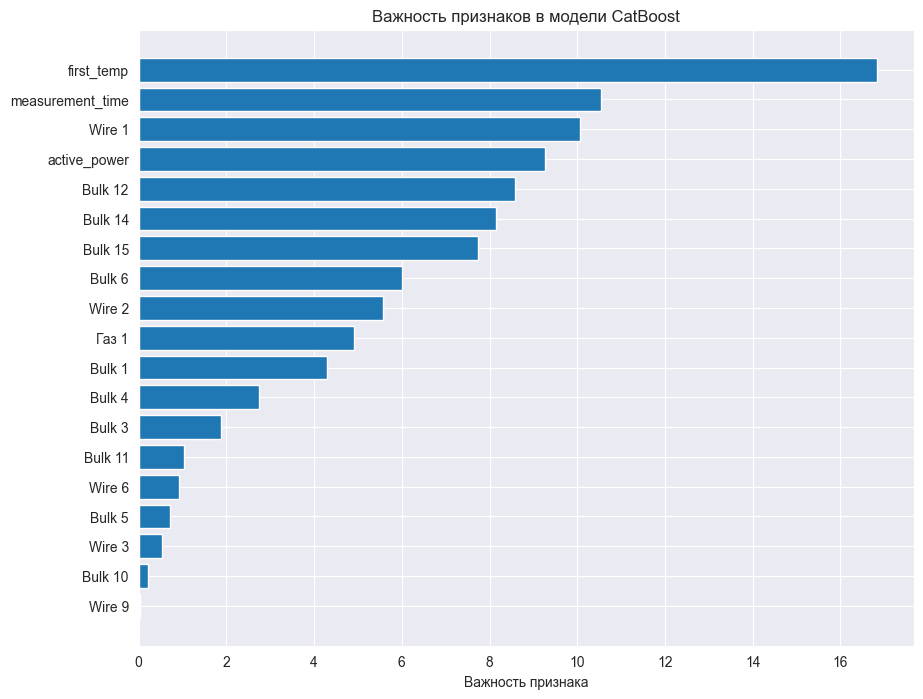

In [56]:
feature_importance = catboost_model.feature_importances_
feature_names = X_train.columns
sorted_idx = feature_importance.argsort()


plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Важность признака')
plt.title('Важность признаков в модели CatBoost')
plt.show()

### Промежуточный вывод по моделирования
Лучшей моделью стал catboost с подобранными гиперпараметрами, он подходит под условия клиента и замечательно проходит проверку на адекватность. Наиболее важными признаками для модели стали начальная температура, время между замерами и объём подаваемого Wire 1.

## Вывод
В ходе выполнения задания клиента мы провели следующие шаги:

Анализ каждой таблицы в отдельности:
   * Пропуски были найдены в таблицах о сыпучих и проволочных материалах, а также в данных о температуре. Пропуски в объёме материалов мы заполнили нулями, что бы показать отсутствие добавки, пропуски во времени их добавки никак не трогали. 
   * Все строки с отсутствующими значения в датафрейме с замерами температуры были удалены и после этого выбраны только те партии у которых было как минимум два замера.
   * В таблице с данными о мощностях была найдена и удалена аномали

Объединение таблиц и создание новых признаков: 
* Мы решили не использовать все 7 таблиц - информация о времени добавления сыпучих и проволочных материалов была признана бесполезной. Остальные же датафреймы были видоизменены и соединены с помощью nner join
* В data_arc_new были суммированы значения мощностей по каждому сплаву, а временной столбец был выкинут.
* Из data_temp мы выбрали в качестве новых столбцов начальную и конечную температуру, а также суммарное время нагревания сплава.
* data_wire_new, data_gas_new, data_bulk_new были добавлены без изменений

Исследовательский анализ объединённого датафрейма и его предобработка
* У столбцов Bulk 2, 7, 8, 9, 13 и Wire 4, 5, 7, 8 было меньше 15 значений отличных от 0, поэтому из-за отсутствия в них полезной информации они были удалены.
* Была построена матрица корреляции и выяснено, что целевой признак неплохо коррелирует с начальной температурой, Wire 1 и Bulk 12, 15
* Также была замечена мультиколлинеарность столбцов с реактивной и активной мощностями, реактивная была удалена.
* Данные разбили на тренировочную и тестовую выборки в соотношении 3 к 1.
* Данные привели к одному масштабу используя StandardScaler.

После этих шагов мы обучили и выбрали наилучшую модель - ею оказался catboost на тесте с метрикой MAE = 6.53. Наиболее важными признаками для модели стали начальная температура, время между замерами и объём подаваемого Wire 1. При этом показатель метрики выше чем у dummy модели, так что catboost прошёл проверку на адекватность. В целом полученную модель можно использовать для имитации технологического процесса, ведь полученная метрика ниже требуемой заказчиком.